In [41]:
#Recorded accuracy = 0.9966

#Courtesy to https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6


#Testing tensorflow import works first
import tensorflow as tf

In [42]:
#Necessary Imports for this algorithm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')


In [43]:
# Load the data, provided by Kaggle.com
train = pd.read_csv("C:\\Users\\JoonH\\Desktop\\Kaggle_data\\digits_train.csv")
test = pd.read_csv("C:\\Users\\JoonH\\Desktop\\Kaggle_data\\digits_test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

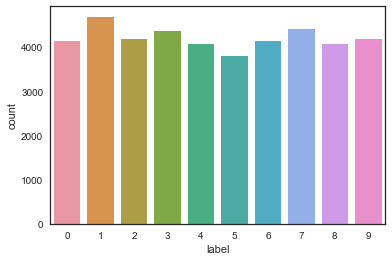

In [44]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

#Plotting count of data for each digit
Y_train.value_counts()

In [45]:
#Principal Component Analysis

#from sklearn.decomposition import PCA

#pca = PCA(n_components = 10)
#X_train = pca.fit(X_train).transform(X_train)


# TODO(0) : change code so that PCA can take place to reduce data into significant components

In [46]:
#Testing for any null or unusable data to remove before training
X_train.isnull().any().describe()



count       784
unique        1
top       False
freq        784
dtype: object

In [47]:
#Testing for any null or unusable data
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [48]:
# Grayscale ormalization of the data
# since CNN converges faster with [0,1] when current data goes [0,255]
X_train = X_train / 255.0
test = test / 255.0

In [49]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [50]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [51]:
# Set the random seed, actually already set before
random_seed = 2

In [52]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)


#I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.
#Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.
#To avoid that, you could use stratify = True option in train_test_split function (Only for >=0.17 sklearn versions).


In [53]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
# Expanded from origianl example model

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [54]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)



In [55]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [56]:
# Set a learning rate annealer, learning rate is checked every two runes to see if accuracy has increased,
# If not showing much improvement learning rate is reduced by factor of 0.5
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.50, 
                                            min_lr=0.00001)

In [57]:
epochs = 35 # Accuracy increases as epoch approaches around 30 or higher
batch_size = 86

In [58]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [59]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.11, # Randomly zoom image 
        width_shift_range=0.11,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.11,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [60]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/35
 - 236s - loss: 0.5595 - acc: 0.8154 - val_loss: 0.1828 - val_acc: 0.9476
Epoch 2/35
 - 235s - loss: 0.1218 - acc: 0.9644 - val_loss: 0.0413 - val_acc: 0.9883
Epoch 3/35
 - 232s - loss: 0.0897 - acc: 0.9747 - val_loss: 0.0521 - val_acc: 0.9845
Epoch 4/35
 - 233s - loss: 0.0727 - acc: 0.9789 - val_loss: 0.0389 - val_acc: 0.9900
Epoch 5/35
 - 231s - loss: 0.0687 - acc: 0.9807 - val_loss: 0.0222 - val_acc: 0.9948
Epoch 6/35
 - 236s - loss: 0.0627 - acc: 0.9825 - val_loss: 0.0344 - val_acc: 0.9910
Epoch 7/35
 - 228s - loss: 0.0621 - acc: 0.9833 - val_loss: 0.0377 - val_acc: 0.9888
Epoch 8/35
 - 228s - loss: 0.0639 - acc: 0.9831 - val_loss: 0.0375 - val_acc: 0.9917

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/35
 - 227s - loss: 0.0418 - acc: 0.9879 - val_loss: 0.0355 - val_acc: 0.9924
Epoch 10/35
 - 227s - loss: 0.0383 - acc: 0.9889 - val_loss: 0.0277 - val_acc: 0.9933

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00025000

In [61]:
#Save the Model
# TODO(): YAML saving and loading model

In [62]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
# Save final prediction results into csv file
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("digits_submission.csv",index=False)